# Complex Feature Engineering Greatly Improves UsedCarPrice Prediction

## Contents

 - Section A	Introduction 
 - Section B	Libraries
 - Section C	Data
 - Section D	EDA
 - Section E	Metrics & Baselines
 - Section F	Feature Engineering
 - Section G	Model Engineering
 - Section H	Evaluation
 - Section I	Final Report

## Section A: Introduction

### A1) Summary

Spectacularly interesting results emerge after complex feature engineering the features of Used Car Prices dataset.

    1. Modeling with the newly engineered features demonstrate 20% reduction in RMSE error compared to modeling with the original features in the dataset. There is a remarkable ~50% reduction in Random Forest RMSE error. Linear Regression Model's RMSE error, training and test accuracy all show an ~30% improvement. Random Forest Test Accuracy shot up to 90%!

    2. What also standsout is the fact that a whole different set of features emerge as the most important ones driving price prediction. Engineered Features like State Purchasing Parity (externally sourced) & Model numerical value stole the show.

    3. Quite some interesting work went into applying extracting information from 'messy' model feature with NLP and in referencing external data for numerical transformation of existing features.

### A2) Project Hypothesis

My hypothesis is new features engineering will have a significant impact on improving the predictive abilities of both regression and classification models. The idea is to start with a a huge data set with complex numerical and categorical features where the model performance is not good to begin with. I will use the features in the dataset to engineer new features by applying a range of techniques from Natural Language Processing to Numerical Transformations. The baseline performance of multiple Machine Learn modeling on pre-feature-engineeded data will be compared against the model performance on the pre-feature-engineeded data to prove my hypothesis.

### A3) Data

The dataset I chose is the Used Car Price prediction data set that contain ~420K records of user car sales price information.

Features include:
    
1. Car make, model, manufacturer, YEAR of manufacture
2. Car specifications: ODOMETER reading, type, VIN, cyclinder, transmission, fuel type
3. Car status: title, condition
4. State and Region of sale

Target is PRICE

(upper case features are numeric)

## Section B: Libraries

This section has the needed python libraries and my customer defined AI/ML functions

### B1) Generic Libraries

In [117]:
# data structures
import pandas as pd
import numpy as np

# my folder path
from pathlib import Path
myfolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/")
BerkAIdatafolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/berkAIdata/")

# for timing program run
import time

# graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

# train/test split
from sklearn.model_selection import train_test_split

# supress warning
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.exceptions import FitFailedWarning 

# code to overcome my system specific errors
# patch for overcoming 'float' error in nump 24.1v
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# Reg models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


# ColTransf / Pipeline / GridSearch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# evaluation libs
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

### B2) ZSRV - Sravan Katragadda custom Libraries

These are my custom defined functions I have developed my years of learning and working in AI & ML

In [5]:
# zsrv function for quick data analyis

def data_quickanalysis(df):
    print('Quick Data Analysis')
    print("Dataset shape:  ",df.shape)
    print("Dataset size:   ",df.size)
    print("# of columns with numerical features  :   ",len(df.select_dtypes(include=['int64', 'float64']).columns.values))
    print("# of columns with categorical features:   ",len(df.select_dtypes(include=['object', 'category']).columns.values))
    
    num_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_features = list(df.select_dtypes(include=['object', 'category','bool']).columns.values)
    #This is a check to see if any features are being missed out
    oth_features = list(set(df.columns.tolist()) - set(num_features) - set(cat_features))
    
    print('Numerical features:', num_features)
    print('Categorical features:', cat_features)
    print('non-num/non-cat features:', oth_features)
    print()
    
def info_df(df):
    
    # io module provides tools for working with text I/O, binary I/O, and raw I/O
    import io
    # Create a buffer to capture the output of df.info()
    buffer = io.StringIO()
    df.info(buf=buffer)
    s = buffer.getvalue()
    # Parse the captured text into a DataFrame
    info_lines = s.split('\n')
    info_data = [line.split(maxsplit=4) for line in info_lines[5:-3]]
    columns = ['#', 'column', '# of non-nulls', 'non-null', 'Data Type']
    info_df = pd.DataFrame(info_data, columns=columns)
    
    
    info_df['# of non-nulls'] = info_df['# of non-nulls'].astype('int64')
    s = df.shape[0]
    info_df['# of nulls'] = s - info_df['# of non-nulls']
    info_df['% of nulls'] = round((info_df['# of nulls'] / s * 100),1)
    
    info_df = info_df.reset_index()
    info_df.index = range(1, len(info_df) + 1)
    info_df = info_df[['column','Data Type','# of nulls','% of nulls']]
    
    return(info_df)

In [6]:
# zsrv function for getting null values information

def nulls_info(df):    

    # getting df with null info
    datasetsize = df.shape[0]
    df_nullinfo = pd.DataFrame(df.isna().sum(),columns=['# of Null Values'])
    df_nullinfo['% of Null Values'] = (df_nullinfo['# of Null Values'] / datasetsize * 100).round(1)
    return df_nullinfo

# --------------------------------------------------------------------------------------------------

def nulls_remove(df):
    
    pre_size = df.shape[0]
    # Removing rows with null values
    df.dropna(inplace=True)
    post_size = df.shape[0]
    print('Data loss in removing nulls:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df

# --------------------------------------------------------------------------------------------------

def nulls_impute(df):
    
    num_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_features = list(df.select_dtypes(include=['object', 'category','bool']).columns.values)
    print(f'There are {len(num_features)} numerical features and {len(cat_features)} categorical features in {datasetname} dataset')
    # Define imputers
    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='constant',fill_value='missing')
    # Numerical Values Imputation
    df[num_features] = numerical_imputer.fit_transform(df[num_features])
    # Categorical Values Imputation
    df[cat_features] = categorical_imputer.fit_transform(df[cat_features])
    # return df
    return df

def IQRoutliers_info(df):
    
    # get Data Loss %
    '''df1 = df
    pre_size = df1.shape[0]
    
    for col in df1.select_dtypes(include=['float64', 'int64']).columns.tolist():
        q1 = df1[col].quantile(0.25)
        q3 = df1[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df1 = df1[(df1[col] >= lower_bound) & (df1[col] <= upper_bound)]
    
    post_size = df1.shape[0]
    print('Data loss in removing nulls:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    '''
    
    # get only numerical columns
    df = df.select_dtypes(include=['number'])
    
    # getting df with outlier info
    datasetsize = df.shape[0]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_IQRoutliersinfo = pd.DataFrame(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum(),columns=['# of Outliers'])
    df_IQRoutliersinfo['% Outliers'] = (df_IQRoutliersinfo['# of Outliers'] / datasetsize * 100).round(1)
    return df_IQRoutliersinfo

def IQRoutliers_remove(df):
    
    # get Data Loss %
    pre_size = df.shape[0]
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns.tolist():
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    post_size = df.shape[0]
    print('Data loss in removing IQQ outliers:', "%.2f" % (100-(post_size / pre_size * 100)) , '%')
    return df

# --------------------------------------------------------------------------------------------------

# zsrv function to get highly correlated features
def get_high_correlated_features(df):
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    # Remove duplicate values and keep the upper triangle
    corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Flatten the matrix and drop NA values (diagonal values)
    corrdf = corr_matrix_upper.stack().reset_index()
    corrdf.columns = ['Feature 1', 'Feature 2', 'PearsonCorrCoef']
    high_corrdf = corrdf[(corrdf['PearsonCorrCoef'] <= -0.7)]
    high_corrdf = corrdf[(corrdf['PearsonCorrCoef'] >= 0.7)]
    
    print(f'There are {len(high_corrdf)} feature combinations that are HIGHLY correlated by Pearson Correlation Coefficient')
    p = len(high_corrdf.query('PearsonCorrCoef > 0.7'))
    print(f'There are {p} feature combinations that are HIGHLY positively correlated by Pearson Correlation Coefficient')
    n = len(high_corrdf.query('PearsonCorrCoef < -0.7'))
    print(f'There are {n} feature combinations that are HIGHLY negatively correlated by Pearson Correlation Coefficient')
    
    return filt_corrdf

# --------------------------------------------------------------------------------------------------

In [224]:
# My custom function for Preprocessing X

def preprocessX(A):
    
    # features
    num_all_features = list(A.select_dtypes(include=['int64', 'float64']).columns.values)
    cat_all_features = list(A.select_dtypes(include=['object', 'category','bool']).columns.values)

    # Numerical Transformation
    num_transform = Pipeline (steps=[
                    ('imp', SimpleImputer(strategy='median')),
                    ('mms', MinMaxScaler())
                    ])

    # Categorical Operations
    cat_transform = Pipeline (steps=[
                    ('imp', SimpleImputer(strategy='constant',fill_value='missing')),
                    ('ore', OrdinalEncoder())
                    ])

    # Column Transformer (CT)
    preprocessor = ColumnTransformer(transformers=[
                    ('num_tran', num_transform, num_all_features),
                    ('cat_tran', cat_transform, cat_all_features),
                    ])
    
    B = preprocessor.fit_transform(A)
    return(B)

In [269]:
# My Custom Function Module for Regression: Training & Evaluation

def evalR(X,y):
    
    # train/test split
    from sklearn.model_selection import train_test_split
    
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    models = [LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor()]
    names  = ['Lin','KNN','DEC','GBR']
    
    RMSE = []
    Acc_Train = []
    Acc_Test = []
    
    for model,name in zip(models,names):
        
        tik = time.time()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        RMSE.append("%.2f" % np.sqrt(mse))

        Acc_Train.append("%.4f" % model.score(X_train, y_train))
        Acc_Test.append("%.4f" % model.score(X_test, y_test))
        
        tok = time.time()
        print(name, 'run time:' , '%.1f' % (tok-tik) , 'seconds')


    # Getting results of Evaluation into a DF
    R1 = pd.DataFrame({'RMSE': RMSE, 'Acc_Train':Acc_Train,'Acc_Test/R2':Acc_Test,})
    R2 = R1.T
    R2.columns = names

    return(R2)

# Section C: Data

In this section data is extracted from the source and details of the data are provided

### C1) Getting Data from source

In [90]:
rawdata = pd.read_csv(BerkAIdatafolder / 'vehicles.csv')

datasetname = 'UsedCarsPrices'

rawdata.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
152161,7311409711,indianapolis,33990,2012.0,ford,super duty f-250 srw,good,8 cylinders,diesel,49678.0,clean,automatic,1FTBF2BT2CEA75283,4wd,full-size,truck,white,in
131228,7315928882,boise,18995,2015.0,audi,q5,NaN,6 cylinders,gas,88033.0,clean,automatic,NaN,4wd,mid-size,SUV,grey,id
3557,7304727682,huntsville / decatur,10500,2012.0,chevrolet,silverado 1500,good,NaN,gas,230000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
179915,7310081006,maine,44995,2017.0,gmc,sierra,like new,NaN,gas,77593.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,me
101774,7303130106,lakeland,14990,2011.0,infiniti,qx56,excellent,8 cylinders,gas,164623.0,clean,automatic,JN8AZ2NF5B9500533,rwd,full-size,SUV,brown,fl


### C2) raw data analyis

my custom module for quick data analysis of raw data

In [91]:
data_quickanalysis(rawdata)

Quick Data Analysis
Dataset shape:   (426880, 18)
Dataset size:    7683840
# of columns with numerical features  :    4
# of columns with categorical features:    14
Numerical features: ['id', 'price', 'year', 'odometer']
Categorical features: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']
non-num/non-cat features: []



### C3) Column data curation

Here only columns will be modified and there will be no change to rows.

End product is neat meaningful columns.

 1. drop irrelevant columns 
 2. column names handling
 3. columns sort

In [359]:
data = rawdata

# 1) removing obviously irrelevant columns
drop_col = ['id','region']
data = data.drop(drop_col, axis=1, errors='ignore')

# 2) column names handling - rename, case handling
data.columns = data.columns.str.lower()
rename_dict = {'vin':'VIN'}
data = data.rename(columns=rename_dict)

# 3) columns sort 
y_column = ['price']
num_features = ['year', 'odometer']
cat_features = ['manufacturer','model','cylinders', 'fuel','transmission','drive',
                'condition','title_status', 'type', 'size', 'paint_color', 'VIN', 'state']
column_order = y_column + num_features + cat_features
data = data[column_order]

print(data.shape)
data.dropna().sample(5)

(426880, 16)


,price,year,odometer,manufacturer,model,cylinders,fuel,transmission,drive,condition,title_status,type,size,paint_color,VIN,state
134226,48988,2020.0,7164.0,gmc,sierra elevation,8 cylinders,gas,automatic,4wd,like new,clean,pickup,full-size,white,3GTP9CEK9LG398079,id
113595,6595,2010.0,85600.0,buick,lucerne cxl,6 cylinders,gas,automatic,fwd,excellent,clean,sedan,full-size,custom,1G4HC5EM6AU131958,fl
399363,3900,2007.0,121078.0,nissan,quest,6 cylinders,gas,automatic,fwd,excellent,clean,van,mid-size,black,5N1BV28U77N121078,va
254141,4850,2009.0,180213.0,honda,odyssey ex-l,6 cylinders,gas,automatic,fwd,excellent,clean,mini-van,full-size,red,5NMSG13D58H154997,nj
373043,33995,2017.0,91250.0,chevrolet,silverado 1500,8 cylinders,gas,automatic,rwd,excellent,clean,pickup,full-size,blue,3GCPCREC8HG113330,tx


### C4) Handling duplicates

Here I analyze duplicates, if any, and make decision on removing or retaining them

In [361]:
print('Duplicate rows:',data.duplicated().sum())
print("%.2f" % (data.duplicated().sum()/len(data)*100), 'percent of rows are duplicates')

Duplicate rows: 127371
29.84 percent of rows are duplicates


In [362]:
data = data.drop_duplicates()

In [363]:
print('Duplicate rows:',data.duplicated().sum())
print("%.2f" % (data.duplicated().sum()/len(data)*100), 'percent of rows are duplicates')

Duplicate rows: 0
0.00 percent of rows are duplicates


### C5) Handling outliers

Here I analyze outliers, if any, and make decision on removing or retaining them

I use my custom defined function for analysis and removal of IQR outliers

In [364]:
print(IQRoutliers_info(data))

# Removing Outlier
data = IQRoutliers_remove(data)

print(IQRoutliers_info(data))

          # of Outliers  % Outliers
price              7348         2.5
year              12711         4.2
odometer           3361         1.1
Data loss in removing IQQ outliers: 9.01 %
          # of Outliers  % Outliers
price              1141         0.4
year                833         0.3
odometer             91         0.0


In [98]:
a

272528

<AxesSubplot:xlabel='price', ylabel='Count'>

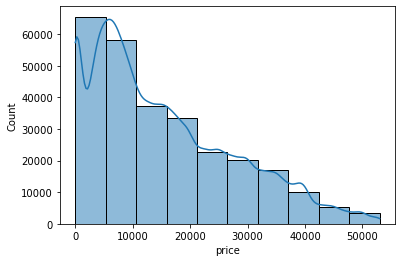

In [366]:
sns.histplot(data['price'], bins=10, kde=True)

In [365]:
# Additionally the Price values are very skewed and has 0 values. Removing the Tail ends of the data wrt Pricing
a = data.shape[0]
data_clean = data[(data['price'] >= 1000) & (data['price'] <= 40000)]
b = data_clean.shape[0]
print('data loss:', "%.1f" %((a-b)/a*100),'%')

data loss: 13.4 %


<AxesSubplot:xlabel='price', ylabel='Count'>

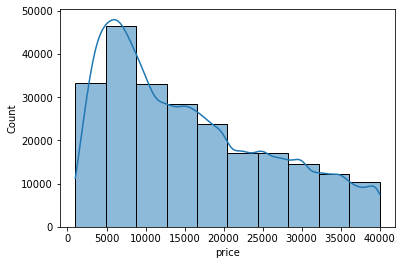

In [86]:
sns.histplot(data_clean['price'], bins=10, kde=True)

In [106]:
data_clean.mean()

price        15686.522516
year          2011.527294
odometer    100485.647151
dtype: float64

In [107]:
data_clean.median()

price       13348.0
year         2013.0
odometer    98043.0
dtype: float64

### C6) Handling nulls

Here I analyze nulls, if any, and make decision on removing or retaining them

I use my custom defined function for analysis and removal of nulls

In [108]:
info_df(data)

,column,Data Type,# of nulls,% of nulls
1,price,int64,0,0.0
2,year,float64,0,0.0
3,odometer,float64,0,0.0
4,manufacturer,object,8570,3.1
5,model,object,2734,1.0
6,cylinders,object,105937,38.9
7,fuel,object,1335,0.5
8,transmission,object,1083,0.4
9,drive,object,79756,29.3
10,condition,object,102450,37.6


In [367]:
# Drop Null values of some columns

drop_col = ['size']
data = data.drop(drop_col, axis=1, errors='ignore')

data = data_clean

dropnull_cols = ['price','year','odometer','manufacturer','fuel','transmission','title_status','state','model']

data.shape

data = data.dropna(subset=dropnull_cols)

data.shape

(221640, 16)

#### using my custom function modules to Impute

Since there are a lot of nulls, we cannot remove the null rows.

we need to impute with values

IMPUTATION STRATEGY:

    1. Numerical Features: fill with mean (no need to consider median which accounts for outliers, since they are removed)
    2. Categorical Features: fill with 'Missing' constant

In [368]:
# Imputings Nulls in Numerical and Categorical variables

print(nulls_info(data))

data = nulls_impute(data)

print(nulls_info(data))

              # of Null Values  % of Null Values
price                        0               0.0
year                         0               0.0
odometer                     0               0.0
manufacturer                 0               0.0
model                        0               0.0
cylinders                83392              37.6
fuel                         0               0.0
transmission                 0               0.0
drive                    62698              28.3
condition                75610              34.1
title_status                 0               0.0
type                     48173              21.7
size                    147852              66.7
paint_color              57407              25.9
VIN                      97466              44.0
state                        0               0.0
There are 3 numerical features and 13 categorical features in Used Car Prices dataset
              # of Null Values  % of Null Values
price                        0  

### C7) Handling special data considerations

Here I fix special data issues like:

    1. special chars cleanup
    2. data type conversions
    3. sometimes feature values recognized as Boolean
    4. others

In [369]:
# Data type conversion of year and odometer

dtypeconvert_dict = {'year':'int64', 'odometer':'int64'}
data = data.astype(dtypeconvert_dict)

### C8) Clean data for Data Analysis

Now my data is clean and ready for data analysis

In [112]:
datasetname = 'Used Car Prices'

UsedCarPrices = data

y_column = ["price"]

# X/y split
UsedCarPrices_X  = data.drop(y_column, axis=1, errors='ignore')
UsedCarPrices_y  = data[y_column].copy()

In [113]:
data_quickanalysis(UsedCarPrices)

Quick Data Analysis
Dataset shape:   (221640, 16)
Dataset size:    3546240
# of columns with numerical features  :    3
# of columns with categorical features:    13
Numerical features: ['price', 'year', 'odometer']
Categorical features: ['manufacturer', 'model', 'cylinders', 'fuel', 'transmission', 'drive', 'condition', 'title_status', 'type', 'size', 'paint_color', 'VIN', 'state']
non-num/non-cat features: []



## Section D: Exploratory Data Analysis

This section contains analysis including visualizations of :

1. Data Descriptive Statistics: statistical analysis including distribution analysis

2. Data Inferential Statistics: relations between features and between features & y, important features, hypothesis testing

### D1) Descriptive Statistics

 - statistics summary for num_features
 - unique value analysis for cat_features
 - distribution of features visualized with graphs like Histograms, Box plots and other

#### Complete Descriptive Statistics of numerical features with oob python function

In [115]:
UsedCarPrices.describe()

,price,year,odometer
count,221640.000000,221640.000000,221640.000000
mean,15750.911465,2011.625235,100172.168972
std,10426.706599,5.661280,61182.745453
min,1000.000000,1994.000000,0.000000
25%,6990.000000,2008.000000,48047.500000
50%,13499.000000,2013.000000,97977.000000
75%,23000.000000,2016.000000,143004.750000
max,40000.000000,2022.000000,285961.000000


#### Numerical Values Distribution Analysis

Box Plots showing the:
1) Numerical Variables Distribution Analysis
2) Outliers outside the whiskers of the box plot


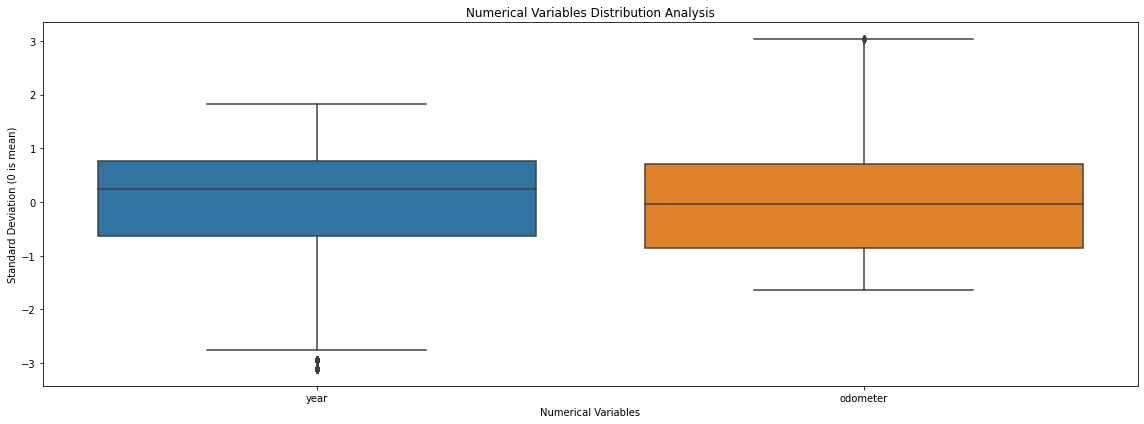

In [116]:
print('Box Plots showing the:')
print('1) Numerical Variables Distribution Analysis')
print('2) Outliers outside the whiskers of the box plot')


df = UsedCarPrices_X.select_dtypes(include=['number'])
x_transform = pd.DataFrame(StandardScaler().fit_transform(df),columns=(df.columns.tolist()))
df_standardscaled = x_transform
plt.figure(figsize=(16,6))
sns.boxplot(data=df_standardscaled)
#sns.swarmplot(data=df,size=2)
plt.title("Numerical Variables Distribution Analysis");
plt.xlabel('Numerical Variables'); plt.ylabel('Standard Deviation (0 is mean)')
plt.tight_layout() ; plt.show()

In [ ]:
# Plot shows almost NO outliers since they have been removed
# Whisker for the year is skewed to the earlier years
# whisker fot the odometer is skewed to the high numbers
# This is intuitive since they are used cars and likely to be more old and higher odometer readings

#### Categorical Features Analysis

Here I show:

    1. Unique value counts for each Categorical feature
    2. Bar Plot of unique value in each categorical feature and their corresponding average prices
 
#### How to read the Horizontal lines on the plot

For each Plot I have shown:
a) the Mean of prices in solid line, 
b) 1st standard deviations in dashed line, 
c) 2nd standard deviation in dotted line

if a value, for example '8 cyclinders' is above 1 std deviation line, it means it is at a whole different level of pricing compared to other cars

manufacturer
ford               35647
chevrolet          27204
toyota             19909
honda              14020
nissan             11565
jeep               10165
bmw                 8070
gmc                 7676
dodge               7141
ram                 6988
subaru              6473
hyundai             6235
mercedes-benz       5756
volkswagen          5629
kia                 5001
lexus               4916
audi                4340
chrysler            3801
cadillac            3734
acura               3531
mazda               3299
buick               3122
infiniti            2912
lincoln             2330
volvo               2038
mitsubishi          1977
mini                1538
pontiac             1295
jaguar              1069
rover                900
saturn               733
mercury              689
porsche              573
fiat                 491
alfa-romeo           480
tesla                301
harley-davidson       76
land rover             9
aston-martin           4
ferrari     

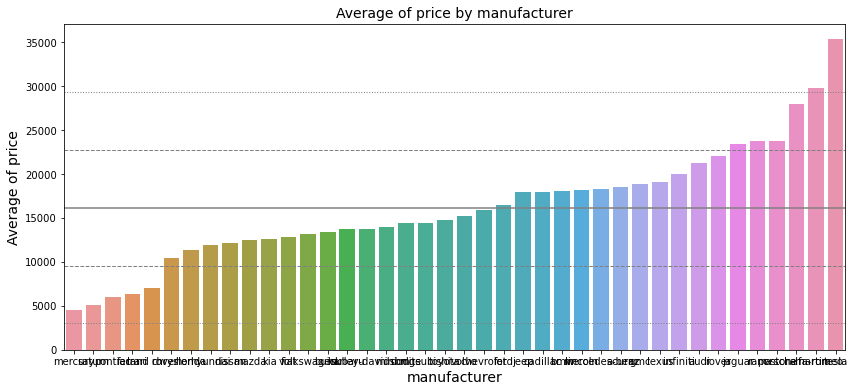

cylinders
missing         83392
6 cylinders     53521
4 cylinders     48653
8 cylinders     33443
5 cylinders      1136
10 cylinders      740
other             415
3 cylinders       296
12 cylinders       44
dtype: int64


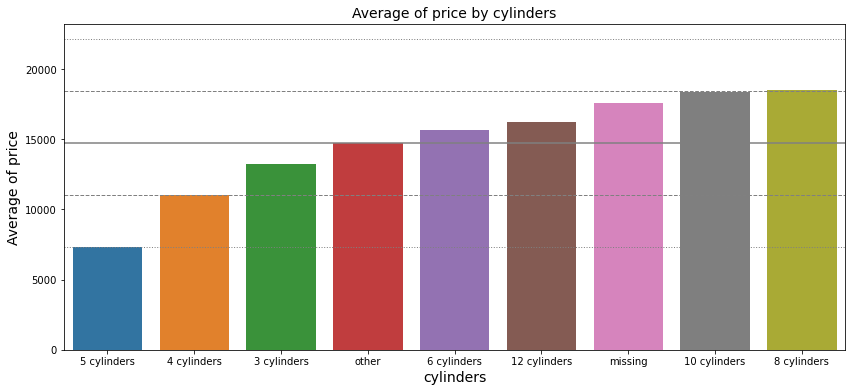

fuel
gas         194870
other        13897
diesel        8815
hybrid        3231
electric       827
dtype: int64


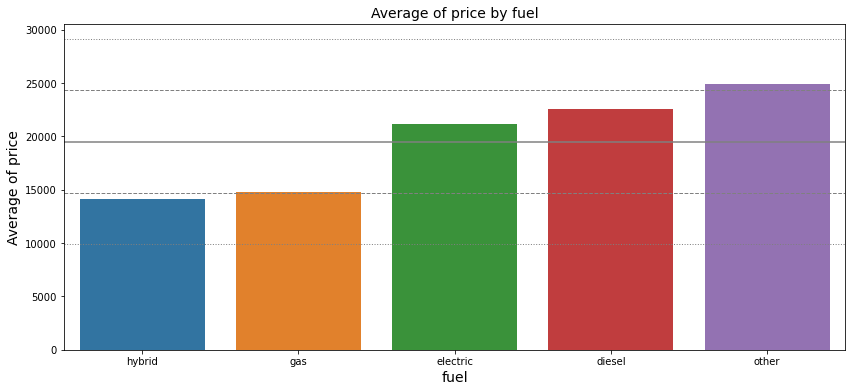

transmission
automatic    179433
other         30565
manual        11642
dtype: int64


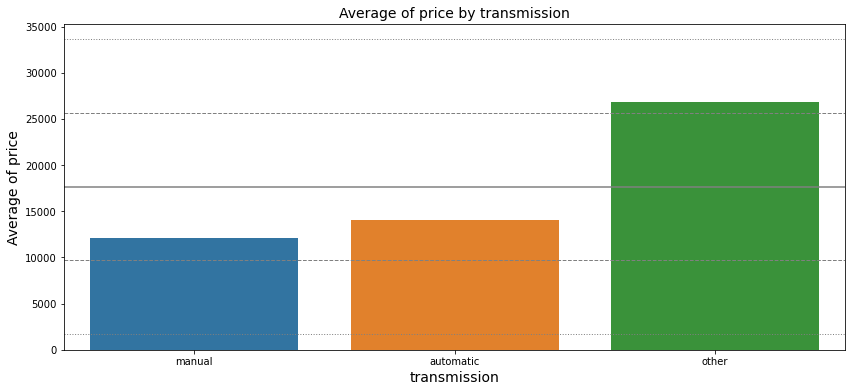

drive
fwd        65124
4wd        64957
missing    62698
rwd        28861
dtype: int64


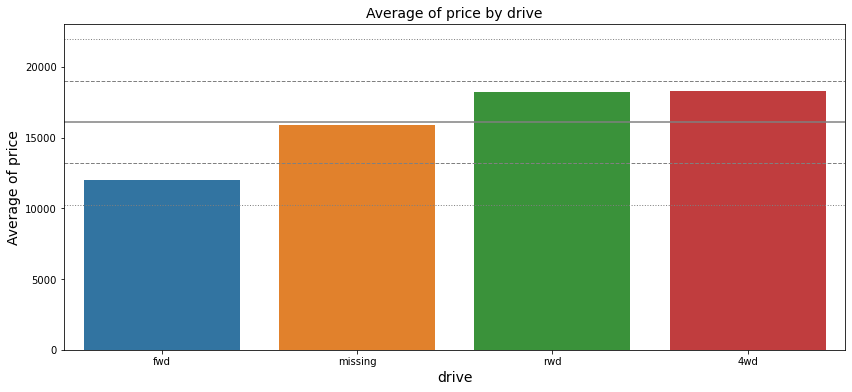

condition
missing      75610
good         69999
excellent    57952
like new     13230
fair          3974
new            548
salvage        327
dtype: int64


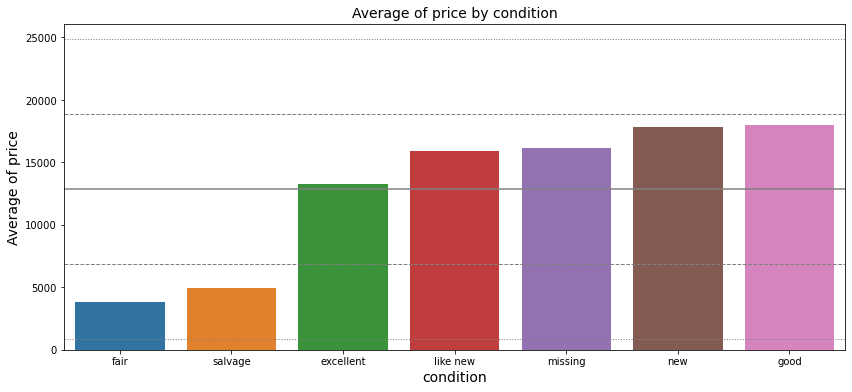

title_status
clean         212093
rebuilt         5411
salvage         2858
lien            1099
missing          125
parts only        54
dtype: int64


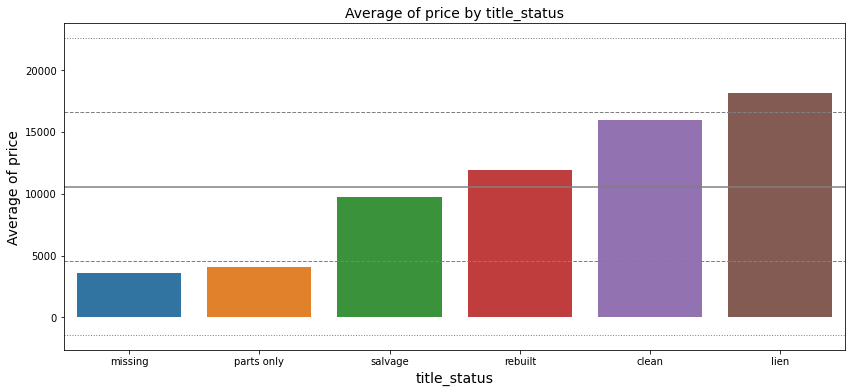

type
sedan          50715
missing        48173
SUV            43349
pickup         18290
truck          14423
other           9865
hatchback       9764
coupe           8634
wagon           6203
van             4524
convertible     3824
mini-van        3344
offroad          335
bus              197
dtype: int64


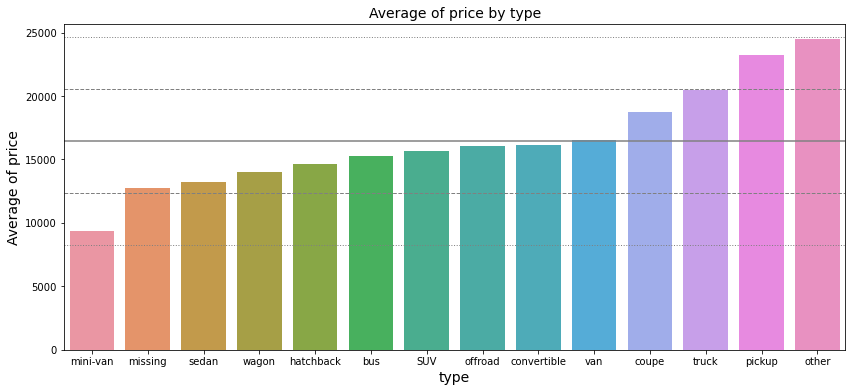

size
missing        147852
full-size       36999
mid-size        23101
compact         11870
sub-compact      1818
dtype: int64


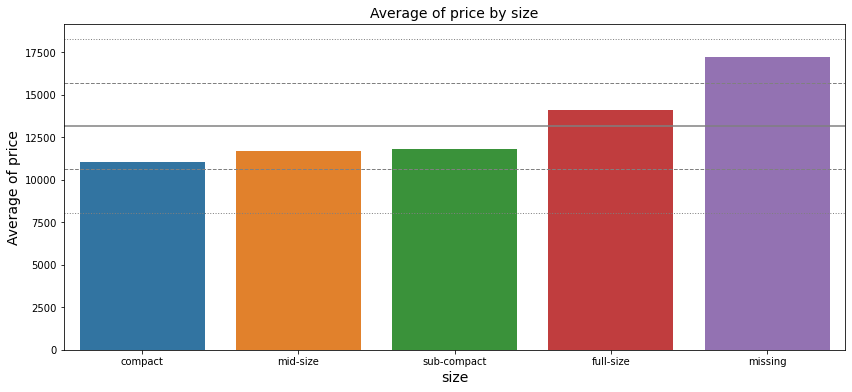

paint_color
missing    57407
white      40762
black      34332
silver     25775
blue       17715
red        16201
grey       15340
green       4157
custom      3910
brown       3833
yellow       924
orange       899
purple       385
dtype: int64


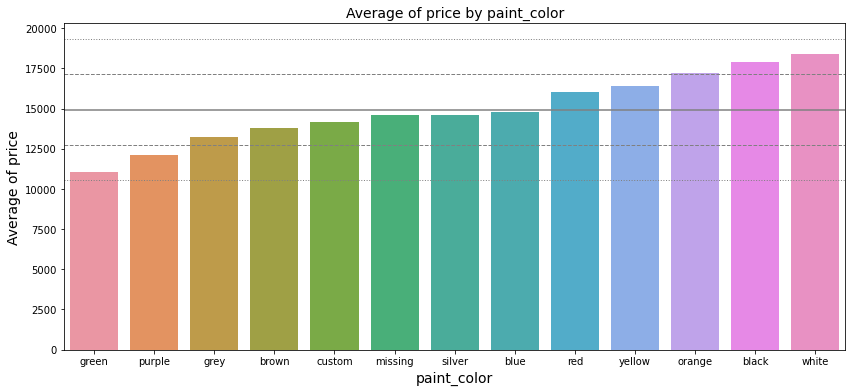

In [353]:
df = UsedCarPrices

cols = ['manufacturer', 'cylinders', 'fuel', 'transmission', 'drive', 
        'condition', 'title_status', 'type', 'size', 'paint_color']


for col in cols:
    grouped_df = df.groupby(col)['price'].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='price', ascending=True)
   
    plt.figure(figsize=(14,6))
    sns.barplot(x=col, y='price', data=grouped_df)
        # Set plot title and labels
    plt.title(f'Average of price by {col}',fontsize=14)
    plt.xlabel(col,fontsize=14)
    plt.ylabel('Average of price',fontsize=14)
    m = grouped_df['price'].mean() ; d = grouped_df['price'].std()
    plt.axhline(y=(m), color='grey', linewidth=1.5, linestyle='-')
    plt.axhline(y=(m-d), color='grey', linewidth=1, linestyle='--')
    plt.axhline(y=(m+d), color='grey', linewidth=1, linestyle='--')
    plt.axhline(y=(m-(2*d)), color='grey', linewidth=1, linestyle=':')
    plt.axhline(y=(m+(2*d)), color='grey', linewidth=1, linestyle=':')
    
    print(df.groupby(col).size().sort_values(ascending=False))
    
    plt.show()

### D2) Inferential Statistics

- relations among features
 - relations between features and target variable (y)
 - hypothesis testing
 - Statistical analysis for finding important features - Chi, ANOVA, F1, t-test, other

#### Correlation Matrix for Numerical Variables

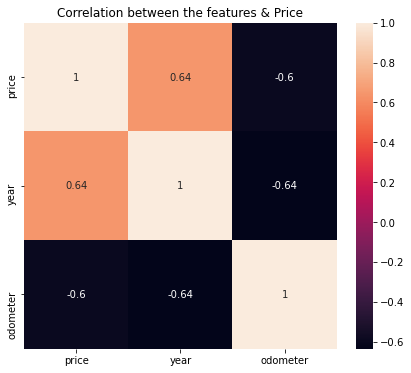

In [370]:
# Correlation among Features & also between Features & Car Price

plt.figure(figsize=(7,6))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation between the features & Price')
plt.show()

There is STRONG negative correlation between Year and Odometer, which is intuitive.

The older the year the higher the mileage

There is WEAK positive correlation between Price and year

There is WEAK negative correlation between Price and Odometer reading

#### SCATTER PLOTS for numerical features & Price relationship

Since there are too many categorical features influencing the price, the scatter plot will be messy in 2D.

So I am looking at selective cars to demonstrate the relationship in 2D.

In below plots, I show the relations for the subdata for my favorite car ACURA

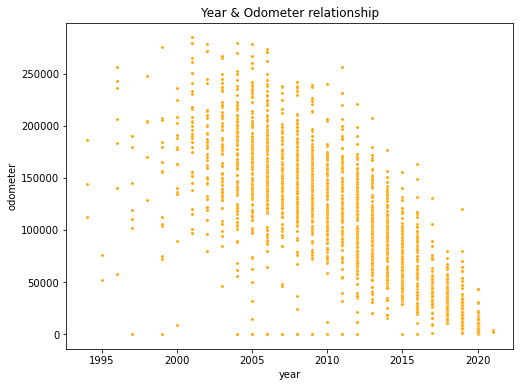

In [371]:
# Scatter Plot Year feature & Odometer feature

plt.figure(figsize=(8, 6))
sns.scatterplot(data=UsedCarPrices.query('manufacturer=="acura"'), x='year', y='odometer',s=10,color='orange')
plt.title('Year & Odometer relationship')
plt.show()

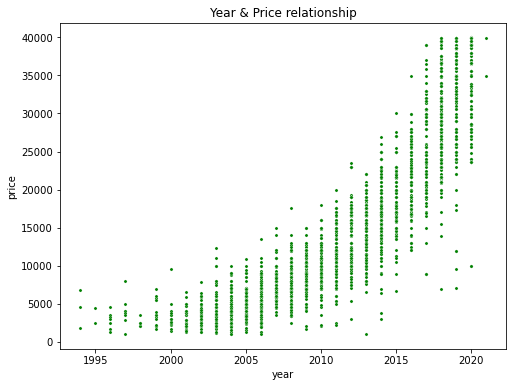

In [372]:
# Scatter Plot Year feature & Price

plt.figure(figsize=(8, 6))
sns.scatterplot(data=UsedCarPrices.query('manufacturer=="acura"'), x='year', y='price',s=10,color='green')
plt.title('Year & Price relationship')
plt.show()

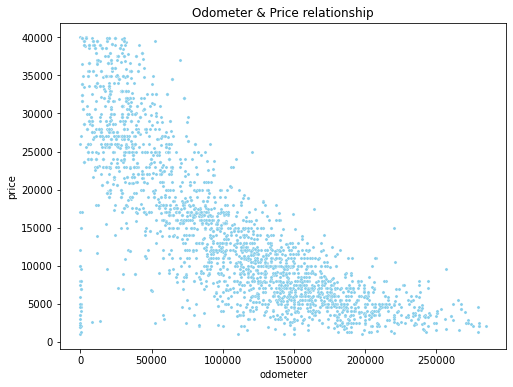

In [373]:
# Scatter Plot Odometer feature & Price

plt.figure(figsize=(8, 6))
sns.scatterplot(data=UsedCarPrices.query('manufacturer=="acura"'), x='odometer', y='price',s=10,color='skyblue')
plt.title('Odometer & Price relationship')
plt.show()

## Section E: Metrics & Baseline

This section contains:

 1. considerations of Metrics for Test/Evaluation Design
 2. Baseline score against which we will compare

### E1) Metrics

for this classification problem 5 metrics will be considered:

    1. RMSE
    2. Training Accuracy
    3. Test Accuracy

### E2) Baseline before feature engineering

The hypothesis of this project is to prove the benefit of Feature Engineering.

So I am taking a baseline of 4 models Linear Regression, KNN, Decision Tree, GradientBoostingRegressor

with the clean data before feature engineering.

feature scaling will still be applied

In [122]:
# Running Evaluation on pre-feature-engineered Clean and Scaled data

UsedCarPrices_X_scaled = preprocessX(UsedCarPrices_X)

tik = time.time()

eval_baseline = evalR(UsedCarPrices_X_scaled,UsedCarPrices_y)

tok = time.time()
print('run time:' , '%.1f' % (tok-tik) , 'seconds')

eval_baseline

Lin run time: 0.2 seconds
KNN run time: 5.8 seconds
DEC run time: 2.6 seconds
GBR run time: 34.3 seconds
run time: 42.9 seconds


,Lin,KNN,DEC,GBR
RMSE,6870.81,5766.79,4647.51,4764.27
Acc_Train,0.5584,0.8017,0.9999,0.7871
Acc_Test/R2,0.5651,0.6936,0.8010,0.7909


#### I ran Random Forest in previous instances but I changed to Decision Tree because the run time for each iteration of Random Forest is >6 minutes in baseline run and >10 mins in feature engineer run. However, I have the values of the earlier run. Appending them to the evaluation matrix

In [268]:
eval_baseline

,Lin,KNN,DEC,GBR,RAN
RMSE,6870.81,5766.79,4647.51,4764.27,6178.9200
Acc_Train,0.5584,0.8017,0.9999,0.7871,0.9618
Acc_Test/R2,0.5651,0.6936,0.8010,0.7909,0.7503


# Section F: Feature Engineering


Here I Engineer new features out of existing features

This section is the main cruz of my project

Techniques Used in this Section:

    1. Natural Language Processing
    2. Python car-industry domain specific modules (VIN)
    3. Referencing external Data for transforming data in dataset
    3. Numerical Transformations
    3. Binning 
    4. Mapping categorical values to numerical values

## F1) New Numerical Features

In [153]:
# Data

UsedCarPrices_wNF = UsedCarPrices

#### New Feature 01 - State Regional Price Parity

Detail: State data is relatively meaningless without taking the price adjustment by state into consideration. Regional price parity measures the cost of living differences between states by comparing the prices of goods and services. This should explain the variability of price for the same car across states.

Technique used: External Data sourcing, Categorical values to numerical values mapping

In [154]:
state_RPP_map = { "state": ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"],
                 "RPP": [87.8, 102, 99.9, 86.6, 112.5, 102.3, 106.4, 98, 112.8, 98.6, 91.7, 111.3, 96.6, 98.6, 91.8, 88.4, 90, 89.4, 90.6, 100.8, 105, 109.4, 93.4, 97.7, 87.3, 91.1, 90.3, 89.8, 96.4, 107.6, 108.8, 91, 107.6, 94.2, 88.7, 91.5, 88.8, 106.6, 96.2, 104.7, 93.6, 88, 91.8, 97.5, 94.5, 101.1, 102.1, 109.8, 89.2, 92.3, 91.9]}
state_RPP_map = pd.DataFrame(state_RPP_map)
UsedCarPrices_wNF['state'] = UsedCarPrices_wNF['state'].str.upper()
UsedCarPrices_wNF['state_RPP'] = UsedCarPrices_wNF['state'].map(state_RPP_map.set_index('state')['RPP'])

#### New Feature 02 - years_from_now

Detail: taking the difference between the current year and manufacture year scales the year for better use than just the year by itself

Technique used: numerical transformation

In [155]:
import datetime
this_year = datetime.datetime.now().year
UsedCarPrices_wNF['years_from_now'] = this_year - UsedCarPrices_wNF['year']

#### New Feature 03 - Number of Cylinders

Detail: converting the cylinders into numerical, where missing the average value of cylinders is added

Technique used: Categorical values to numerical values mapping

In [156]:
cylinders_map = {'8 cylinders':8, '6 cylinders':6, '4 cylinders':4, '5 cylinders':5,
                 'other':5.94, 'missing':5.94,'3 cylinders':3, '10 cylinders':10, '12 cylinders':12}
UsedCarPrices_wNF['cylinders_number'] = UsedCarPrices_wNF['cylinders'].map(cylinders_map)

#### New Feature 04 - Title Status Scale

Detail: converting title status to numerical. bad titles given low, good titles given high, missing is average

Technique used: Categorical values to numerical values mapping

In [157]:
titlestatus_map = {'parts only':1,'salvage':2,'missing':2.5,'rebuilt':3,'clean':4,'lien':5}
UsedCarPrices_wNF['title_status_scale'] = UsedCarPrices_wNF['title_status'].map(titlestatus_map)

#### New Feature 05 - size scale

Detail: Assigning numerical values to Car size. Note that I have assigned highest rating to 'missing' values. This is because of the missing values having a whol standard deviation better car price. This could be because the missing values could have a higher proportion of SUVs, Pickups and Trucks.

Technique used: numerical transformation partly using Target Encoding logic

In [158]:
size_map = {'sub-compact':0.75,'compact':1,'mid-size':2.5,'full-size':4,'missing':5}
UsedCarPrices_wNF['size_scale'] = UsedCarPrices_wNF['size'].map(size_map)

### Application of Natural Language Processing

#### New Feature 06 - NLP on Model column

Detail: Here I use NLP techniques to extract meaningful information from the messy Model field.

Logic: 

    1. extract all text in model column
    2. get 50 most common non-trivial phrase
    3. Create new field model_nlp when with these words if they exist in a particular row in the model column
    4. Next I target encode the average car price for these values into the model_num_value

Technique used: NLP, Target Encoding

In [159]:
import pandas as pd
from collections import Counter
import re

df = UsedCarPrices

# Converting all text in model column into a blob of text
text = ' '.join(df['model'].astype(str))

# Get words from the text blob
words = re.findall(r'\b\w+\b', text.lower())
words = [word for word in words if len(word) >= 3]

# counts for words
word_counts = Counter(words)

# Get 50 most common words

most_common_words = word_counts.most_common(200)
most_common_words = pd.DataFrame(most_common_words)
print(most_common_words[1].sum())
most_common_words.head()

295214


,0,1
0,sport,12962
1,1500,10857
2,sedan,8894
3,silverado,7733
4,cab,6115


In [160]:
# Getting New Model Column with only the most common words

# custom fn for populating common word into new model columm
def replace(row, list):
    for item in list:
        if item in row['model']:
            return item
    return 'other'

list_of_words = most_common_words[0].tolist()

tik = time.time()
UsedCarPrices_wNF['model_nlp'] = df.apply(lambda row: replace(row, list_of_words), axis=1)
tok = time.time()

print('run time:','%.1f' % (tok-tik))

run time: 35.0


In [161]:
# Target Encode Model NLP values

price_by_model = UsedCarPrices_wNF.groupby('model_nlp')['price'].mean()

UsedCarPrices_wNF['model_numvalue'] = UsedCarPrices_wNF['model_nlp'].map(price_by_model)
UsedCarPrices_wNF['model_numvalue'] = UsedCarPrices_wNF['model_numvalue'].round(2)

In [162]:
UsedCarPrices_wNF.sample(5)

,price,year,odometer,manufacturer,model,cylinders,fuel,transmission,drive,condition,...,VIN,state,state_RPP,years_from_now,cylinders_number,title_status_scale,size_scale,model_nlp,model_numvalue,condition_scale
376056,9995.0,2014,88867,kia,optima,4 cylinders,gas,automatic,missing,like new,...,missing,TX,97.5,10,4.00,4.0,5.0,optima,11466.75,4.5
373966,1600.0,2004,122000,honda,odyssey,missing,gas,automatic,missing,missing,...,missing,TX,97.5,20,5.94,2.5,5.0,odyssey,9771.27,2.5
256070,12000.0,2012,80920,cadillac,cts 3.6l v6 premium,6 cylinders,gas,automatic,4wd,like new,...,missing,NJ,108.8,12,6.00,4.0,4.0,premium,22706.78,4.5
21023,37990.0,2019,8350,tesla,model 3 standard range,missing,other,other,rwd,good,...,5YJ3E1EA3KF474180,AR,86.6,5,5.94,4.0,5.0,and,19410.89,5.0
336609,26379.0,2014,100000,chevrolet,silverado 2500 hd lt,8 cylinders,gas,automatic,4wd,excellent,...,missing,PA,96.2,10,8.00,4.0,4.0,silverado,20123.39,2.5


#### New Feature 07 - condition_scale

Detail: converting car condition to numerical. bad condition given low, good condition given high, missing is average.

**exception** target encoding excellent to 2.5, good to 5

Technique used: Categorical values to numerical values mapping

In [163]:
condition_map = {'salvage':.5,'fair':.5,'missing':2.5,'excellent':2.5,'like new':4.5,'new':5,'good':5}
UsedCarPrices_wNF['condition_scale'] = UsedCarPrices_wNF['condition'].map(condition_map)

#### Dropping Features from which the numerical features were created

In [164]:
# Drop Old features
drop_col = ['year','cylinders','title_status', 'state','state_RPP_value','size','model','model_nlp','condition']
UsedCarPrices_wNF = UsedCarPrices_wNF.drop(drop_col, axis=1, errors='ignore')

## F2) New Categorical Features

#### New Feature 08 - Country of Origin

Detail: The VIN field is NOT a junk field rather it is an entire repository of information by in itself. I am using some python modules available to extract the Country of Origin information from the VIN. There is a huge potential to derive much more information from it.

Technique used: Python car-industry domain specific modules (VIN)

In [165]:
from vininfo import Vin

def get_country_or_other(vin):
    if len(vin) == 17:
        try:
            return Vin(vin).country
        except:
            return 'other'
    else:
        return 'other'
    
UsedCarPrices_wNF['countryoforigin'] = UsedCarPrices_wNF['VIN'].apply(get_country_or_other)

countrylist = ['United States','Mexico','Japan','Germany','Canada']

UsedCarPrices_wNF['countryoforigin'] = UsedCarPrices_wNF['countryoforigin'].apply(lambda x: x if x in countrylist else 'Other')

#### New Feature 09 - Luxury Brand

Detail: Converting Manufacture column into Luxury Column, by identifying certain manufacturers as luxury brands

Technique used: Mapping, Binning

In [166]:
luxury_car_brands = ["cadillac", "lexus", "jaguar", "volvo", "audi", "infiniti", 
                     "lincoln", "alfa romeo", "acura", "mercedes-benz", "bmw", "porsche", "ferrari", "tesla"]
UsedCarPrices_wNF['luxury_brand'] = UsedCarPrices_wNF['manufacturer'].apply(lambda x: 'Yes' if x in luxury_car_brands else 'No')

#### New Feature 10 - Car Type Bins

Detail: Converting Car Types with huge unique values into car type bins

Technique used: Mapping, Binning

In [167]:
# New Cat Feature 03: cartypebins
manyto1_dict = {('sedan', 'wagon', 'hatchback'): 'passenger', 
                ('convertible', 'coupe'): 'special',
                ('pickup', 'truck', 'van', 'mini-van', 'offroad'): 'truck/van', 
                ('bus', 'other', 'missing'): 'other'}
cartype_map = {key: value for keys, value in manyto1_dict.items() for key in keys}
cartype_map = {**cartype_map, **{'SUV':'SUV'}}
UsedCarPrices_wNF['cartypebins'] = UsedCarPrices_wNF['type'].map(cartype_map)

#### New Feature 11 - Transmission_Other

Detail: automatic and manual transmission have about the same average price, however the other one is a whole standard deviation higher. So clubbing automatic and manual. These could be special tranmissions - high-speed automatics, electrics, others

Technique used: Mapping, Binning

In [168]:
transmission_map = {'other':'Y', 'automatic':'N', 'manual':'N'}
UsedCarPrices_wNF['transmission_other'] = UsedCarPrices_wNF['transmission'].map(transmission_map)

#### New Feature 12 - Paint Colors

Detail: Binning Car Paint Colors based on their average pricing

Technique used: Binning

In [169]:
# New Cat Feature 04: paintcolor_priceness
manyto1_dict = {('black', 'white','orange'):'high', 
                ('grey', 'purple', 'green'):'low',
                ('blue', 'red', 'silver', 'missing', 'brown', 'yellow', 'custom'):'median'}             
paintcolor_map = {key: value for keys, value in manyto1_dict.items() for key in keys}
UsedCarPrices_wNF['paintcolorpriciness'] = UsedCarPrices_wNF['paint_color'].map(paintcolor_map)

#### New Feature 13 - New Feature from Manufacture

Detail: Taking only the names of manufacturer who give the top 85% of the count and setting others to 'other'. OneHotCoding with all the ~40 manufactures is not possible to run in my system

Technique used: Binning

In [216]:
lesscount_manuf = {'cadillac': 'other', 'chrysler': 'other', 'acura': 'other', 'mazda': 'other', 'buick': 'other', 'infiniti': 'other', 'lincoln': 'other', 'volvo': 'other', 'mitsubishi': 'other', 'mini': 'other', 'pontiac': 'other', 'jaguar': 'other', 'rover': 'other', 'saturn': 'other', 'mercury': 'other', 'porsche': 'other', 'fiat': 'other', 'alfa-romeo': 'other', 'tesla': 'other', 'harley-davidson': 'other', 'ferrari': 'other', 'land rover': 'other', 'aston-martin': 'other'}

UsedCarPrices_wNF['manuf_new'] = UsedCarPrices_wNF['manufacturer']
UsedCarPrices_wNF['manuf_new'] = UsedCarPrices_wNF['manufacturer'].replace(lesscount_manuf)

#### Dropping Features from which the categorical features were created

In [220]:
# Drop Old features
drop_col = ['manufacturer','VIN','type', 'transmission','paint_color']
UsedCarPrices_wNF = UsedCarPrices_wNF.drop(drop_col, axis=1, errors='ignore')

## F3) Final look at Feature Engineered dataset

In [221]:
UsedCarPrices_wNF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221640 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                221640 non-null  float64
 1   odometer             221640 non-null  int64  
 2   fuel                 221640 non-null  object 
 3   drive                221640 non-null  object 
 4   state_RPP            221640 non-null  float64
 5   years_from_now       221640 non-null  int64  
 6   cylinders_number     221640 non-null  float64
 7   title_status_scale   221640 non-null  float64
 8   size_scale           221640 non-null  float64
 9   model_numvalue       221640 non-null  float64
 10  condition_scale      221640 non-null  float64
 11  countryoforigin      221640 non-null  object 
 12  luxury_brand         221640 non-null  object 
 13  cartypebins          221640 non-null  object 
 14  transmission_other   221640 non-null  object 
 15  paintcolorpricin

# Section G: Model Engineering


The very Hypothesis of this project is to evaluate the effect of Feature Engineering on Model Accuracy. We cannot vary more than 1 variable for valid comparison. So for the purpose of this project, we will not modify the models, but run the models on the same Evaluation Models and Metrics on which we can our Pre-Feature-Engineered Data

# Section H: Evaluation


Lets run the earlier establish models and metrics on the feature engineered data

## H1) Evaluating Feature Engineering Performance

In [222]:
# X/y split of feature engineered data

y_column = ['price']
UsedCarPrices_wNF_X  = UsedCarPrices_wNF.drop(y_column, axis=1, errors='ignore')
UsedCarPrices_wNF_y  = UsedCarPrices_wNF[y_column].copy()

In [223]:
# Running Evaluation on post-feature-engineered Clean and Scaled data

UsedCarPrices_X_scaled = preprocessX(UsedCarPrices_wNF_X)

tik = time.time()

eval_final = evalR(UsedCarPrices_X_scaled,UsedCarPrices_wNF_y)

tok = time.time()
print('run time:' , '%.1f' % (tok-tik) , 'seconds')

eval_final

Lin run time: 0.4 seconds
KNN run time: 108.1 seconds
DEC run time: 3.4 seconds
GBR run time: 57.5 seconds
run time: 169.5 seconds


,Lin,KNN,DEC,GBR
RMSE,5334.77,4953.79,4685.89,4534.37
Acc_Train,0.7424,0.8585,0.9999,0.8152
Acc_Test/R2,0.7361,0.7724,0.7964,0.8093


#### I ran Random Forest a few line below here. Appending those values here.

In [272]:
eval_final

,Lin,KNN,DEC,GBR,RAN
RMSE,5334.77,4953.79,4685.89,4534.37,3320.4000
Acc_Train,0.7424,0.8585,0.9999,0.8152,0.9859
Acc_Test/R2,0.7361,0.7724,0.7964,0.8093,0.8985


## H2) Important Features Identification

In [247]:
y_column = ['price']
UsedCarPrices_wNF_X  = UsedCarPrices_wNF.drop(y_column, axis=1, errors='ignore')
UsedCarPrices_wNF_y  = UsedCarPrices_wNF[y_column].copy()
UsedCarPrices_X_scaled = preprocessX(UsedCarPrices_wNF_X)
X_train, X_test, y_train, y_test = train_test_split(UsedCarPrices_X_scaled, UsedCarPrices_wNF_y, test_size = 0.2)

In [283]:
# Feature Importance by Lin Reg Coefficients

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)

featimp_lin = pd.DataFrame({'features': UsedCarPrices_wNF_X.columns.tolist(), 'coefficients':model_linreg.coef_[0]})

featimp_lin['mod_coeff'] = featimp_lin['coefficients'].abs()

featimp_lin['featurerank_lin'] = featimp_lin['mod_coeff'].rank(ascending=False)
featimp_lin = featimp_lin.sort_values(by='featurerank_lin')

print('These are the Features of the dataset ranked by Coefficient values of Linear Regression')

featimp_lin[['features','coefficients','featurerank_lin']]

These are the Features of the dataset ranked by Coefficient values of Linear Regression


,features,coefficients,featurerank_lin
2,drive,-22419.745959,1.0
6,title_status_scale,20018.709522,2.0
3,state_RPP,13518.436342,3.0
0,odometer,-13483.435162,4.0
4,years_from_now,9243.655546,5.0
11,luxury_brand,2102.924358,6.0
8,model_numvalue,-1482.074106,7.0
13,transmission_other,1384.222093,8.0
5,cylinders_number,1349.537603,9.0
7,size_scale,-937.802262,10.0


In [251]:
# Feature Importance by Random Forest

model_tree = RandomForestRegressor()
model_tree.fit(X_train, y_train)

RandomForestRegressor()

In [254]:
y_pred = model_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print("%.4f" % model_tree.score(X_train, y_train))
print("%.4f" % model_tree.score(X_test, y_test))

3320.4037366360576
0.9859
0.8985


In [284]:
featimp_ran = pd.DataFrame({'features': UsedCarPrices_wNF_X.columns.tolist(), 'ranfeatimp':model_tree.feature_importances_})

featimp_ran['featurerank_ran'] = featimp_ran['ranfeatimp'].rank(ascending=False)
featimp_ran = featimp_ran.sort_values(by='featurerank_ran')


print('These are the Features of the dataset ranked by Coefficient values of Random Forest')
featimp_ran

These are the Features of the dataset ranked by Coefficient values of Random Forest


,features,ranfeatimp,featurerank_ran
2,drive,0.476271,1.0
6,title_status_scale,0.200880,2.0
0,odometer,0.097589,3.0
3,state_RPP,0.044606,4.0
9,condition_scale,0.029336,5.0
15,manuf_new,0.027474,6.0
8,model_numvalue,0.024408,7.0
1,fuel,0.018998,8.0
12,cartypebins,0.017213,9.0
11,luxury_brand,0.017066,10.0


In [351]:
featimp = pd.merge(featimp_lin, featimp_ran, on='features', how='inner')

featimp['rankavg'] = featimp[['featurerank_lin', 'featurerank_ran']].mean(axis=1)

#featimp['rankavg'] = (featimp['featurerank_log'] + (2 * featimp['featurerank_ran']))/3

# Incorrect ranking with reverse order. this value is only for feature importance representation in bar chart
featimp['weightage_for_representation'] = featimp['rankavg'].rank(ascending=False)

featimp['weightedrank'] = featimp['rankavg'].rank()

featimp = featimp.sort_values(by='weightedrank')

featimp_display = featimp[['features','featurerank_lin','featurerank_ran','weightedrank']]

featimp_display = featimp_display.reset_index(drop=True); featimp_display.index = featimp_display.index + 1


featimp_display

,features,featurerank_lin,featurerank_ran,weightedrank
1,drive,1.0,1.0,1.0
2,title_status_scale,2.0,2.0,2.0
3,state_RPP,3.0,4.0,3.5
4,odometer,4.0,3.0,3.5
5,model_numvalue,7.0,7.0,5.0
6,luxury_brand,6.0,10.0,6.5
7,condition_scale,11.0,5.0,6.5
8,years_from_now,5.0,13.0,8.0
9,cartypebins,12.0,9.0,9.0
10,size_scale,10.0,12.0,10.5


## Section I: End Report

 ### I1) Summary of ML Methodology
 
 1. Data columns cyratwere curated - SIR curation - Sorting, Irrelevant column removal, Renaming
 2. Data row issues were handled - DON curation - duplicates removed, outliers removed, nulls
 3. Data data special issues were handled
 4. 48% of the raw data was lost in data cleaning
 5. Detailed Exploratory Data Analysis was done revealing the distribution of categorical variables and the relationship among the features, and their influence of y. This was utilized for the complex feature engineering
 6. Details of Feature engineering are discussed in pertinent section
 7. Metrics Used: RMSE, Training Accuracy, Test Accuracy
 8. Models Used: Linear Regression, K nearest, Decision Tree, Random Forest and Gradient Boosting Regressor


### I2) Final stats & plots comparing scores of pre and post feature engineering

In [350]:
EVALGRID

,RMSE,Train_accuracy,Test_accuracy,RMSE_FeatEngg,Train_accuracy_FeatEngg,Test_accuracy_FeatEngg
Lin,6870.81,0.5584,0.5651,5334.77,0.7424,0.7361
KNN,5766.79,0.8017,0.6936,4953.79,0.8585,0.7724
DEC,4647.51,0.9999,0.8010,4685.89,0.9999,0.7964
GBR,4764.27,0.7871,0.7909,4534.37,0.8152,0.8093
RAN,6178.92,0.9618,0.7503,3320.40,0.9859,0.8985


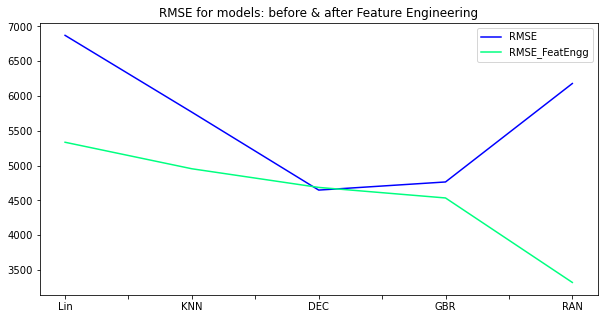

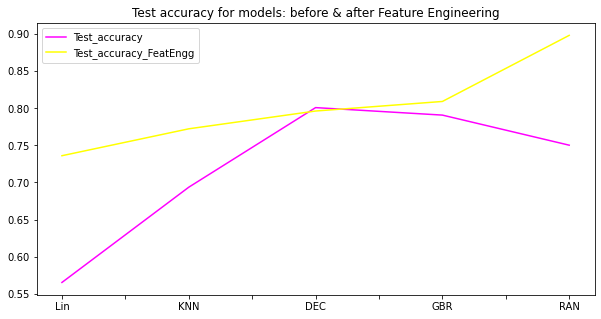

In [348]:

EVALGRID[['RMSE','RMSE_FeatEngg']].plot(kind='line',cmap='winter',figsize=(10,5))
plt.title('RMSE for models: before & after Feature Engineering')


EVALGRID[['Test_accuracy','Test_accuracy_FeatEngg']].plot(kind='line',cmap='spring',figsize=(10,5))
plt.title('Test accuracy for models: before & after Feature Engineering')

plt.show()

### I3) Feature Importance

Feature Importance determined by Linear Regression and Random Foreset Regression and also by intuition are completely changed after the new features are engineered. The State's purchasing parity and Model numerical encoding emerge to be surprisingly important features. Refer to the feature engineer section for details on the features

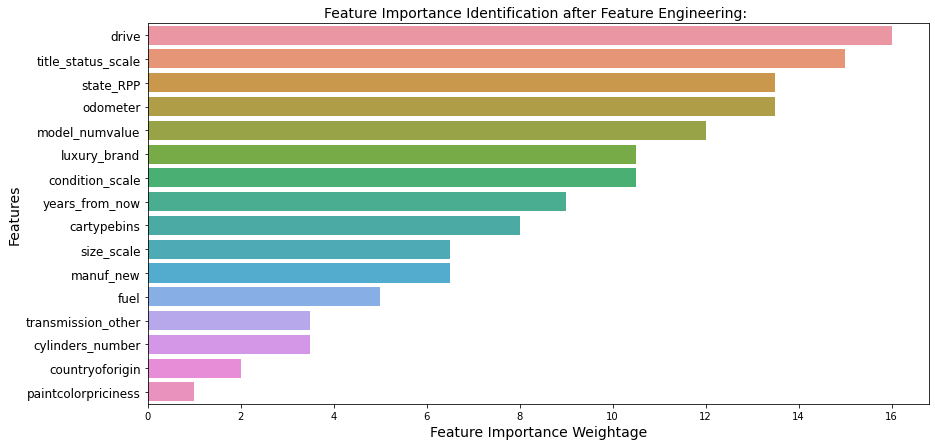

In [374]:
# Feature Importance 

plt.figure(figsize=(14, 7))

sns.barplot(data=featimp.sort_values(by='weightage_for_representation', ascending=False), x='weightage_for_representation', y='features')

plt.title('Feature Importance Identification after Feature Engineering: ', fontsize=14)
plt.xlabel('Feature Importance Weightage', fontsize=14);plt.ylabel('Features', fontsize=14); 
plt.xticks(fontsize=10); plt.yticks(fontsize=12);plt.show()

### I4) Future Work:
    
    1. Further NLP processing of categorical features to extract valuable information
    2. ~20% of the data is lost due to outliers and nulls. These rows can be relooked to see if they can be retained and handled in an appropriate manner.
    3. Dimensionality Reduction and Clustering of One-Hot encoded features created from categorical features to scrape further information from the categorical features without too much computational penalty. 

----------------------------------------------

## Thank you for going through my long work! :)

## My warm appreciations!!

## Please share thoughts if any!!!

----------------------------------------------